# Week 2 - Sampling & Reliability

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import numpy as np #For arrays
import scipy as sp #For some stats
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math


#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## <span style="color:red">*Pitch the Domain of your Project*</span>

<span style="color:red">In the two cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words) and **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words)? [**Note**: your individual or collective project can change over the course of the quarter if new data and/or analysis opportunities arise or if old ones fade away.]

## ***What?*** 
The **text** I am thinking about analyzing is the tweets that talk about China/Chinese in the context of COVID-19. The **social game** I am interested in investigating is broadly racism/aggression toward a country in the context of a pandemic (a major biosecurity threat). Although the occurrence of a disease should not be morally endowed upon or ethnicized toward the country of origin, I believe it is quite prevalent in non-Asian countries nowadays, with President of the United States publicly calling the virus “the Chinese Virus” leading the charge. The **world** where this social game is played is the twitter space. I chose this space because I think it will be relatively easy to investigate this kind of phenomenon in the twitter space for two reasons: (1) there is a lot of data and (2) people can decide to hide behind anonymity (or at least pseudo-anonymity) to express aggression and hospitality. Although the world where this social game is played is the twitter space (or cyberspace) and the **players** of this social game are twitter users, I think this could be an important window to glimpse at the larger social game, world and players – the real-world outside twitter.

## ***Why?***
I believe this pandemic is a very interesting instance where the biosecurity issues and racism intersect with each other. Although racism is among one of the most studied social phenomena in academia, we rarely encountered a case where it was closely bound with biosecurity. From looking at the expression of hatred or hospitality toward China/Chinese online, I think it could give us an insight into how these two can interact. More specifically, I want to investigate if the hatred or hospitality toward China/Chinese intensified as the virus hit the non-Asian countries harder (or spread to the larger population from a relatively small subset of the population) and if the content of the discourse regarding China/Chinese shifted as the disease progressed in the non-Asian countries. This will be beneficial to academia and average person since (1) it will corroborate that there exists or does not exist an ongoing, intensifying racism/hospitality happening at least in cyberspace with quantifiable data and (2) it will provide insight on whether racism/hospitality did or did not grow feeding on the moral panic and biosecurity concern from the disease.

## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication)? (<200 words).

My sample design is to randomly sample tweets that have hashtag related to COVID-19, such as #cornoavirus, on a large time-series starting from early March using twitter API and public datasets. As mentioned before, the **social game** I am interested in is racism/hospitality toward China/Chinese in relation to biosecurity threats (pandemic). This sampling plan will allow me to evaluate how the twitter space fluctuates as the virus hit the countries harder. Another virtue of this sampling plan is that I can divide between tweets that mention China/Chinese (or even Asia/Asians) and tweets that do not. The tweets in the latter group could serve as a good baseline since they will be related to the biosecurity issue, but not directly related to racial issues. One limitation of this sampling plan is that I will depend on twitter APIs and publically available datasets for sampling, so we could not be sure whether this sample is truly random (or unbiased). One way of scaling up my sample will be collecting data from other platforms to see how well my findings generalize, such as Facebook (less anonymous and expected to be less hostile) or Reddit (more anonymous and expected to be more hostile). 

# Annotation Statistics

In [2]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)

## <span style="color:red">*Your turn*</span>

<span style="color:red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the MTurk slides in the Assignment link on Canvas, or by hand with friends.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

I randomly sampled 20 tweets from a dataset of tweets that satisfied following criteria: (1) it had hashtag related to COVDI-19, (2) it was tweeted on March 30th, 2020, (3) it was classified as English tweet (4) it had non-zero `compound` score when analyzed through [`nltk.sentiment.vader.SentimentIntensityAnalyzer`](https://www.nltk.org/api/nltk.sentiment.html). I recruited 10 friends to annotate the sentimentality of the tweets using a method similar to that used in [Dodds et al. (2015)](https://www.pnas.org/content/pnas/112/8/2389.full.pdf). Specifically, I asked them to evaluate the sentiment of the tweet itself by clicking one of the five emojis (smiley-faces). Following is an example:

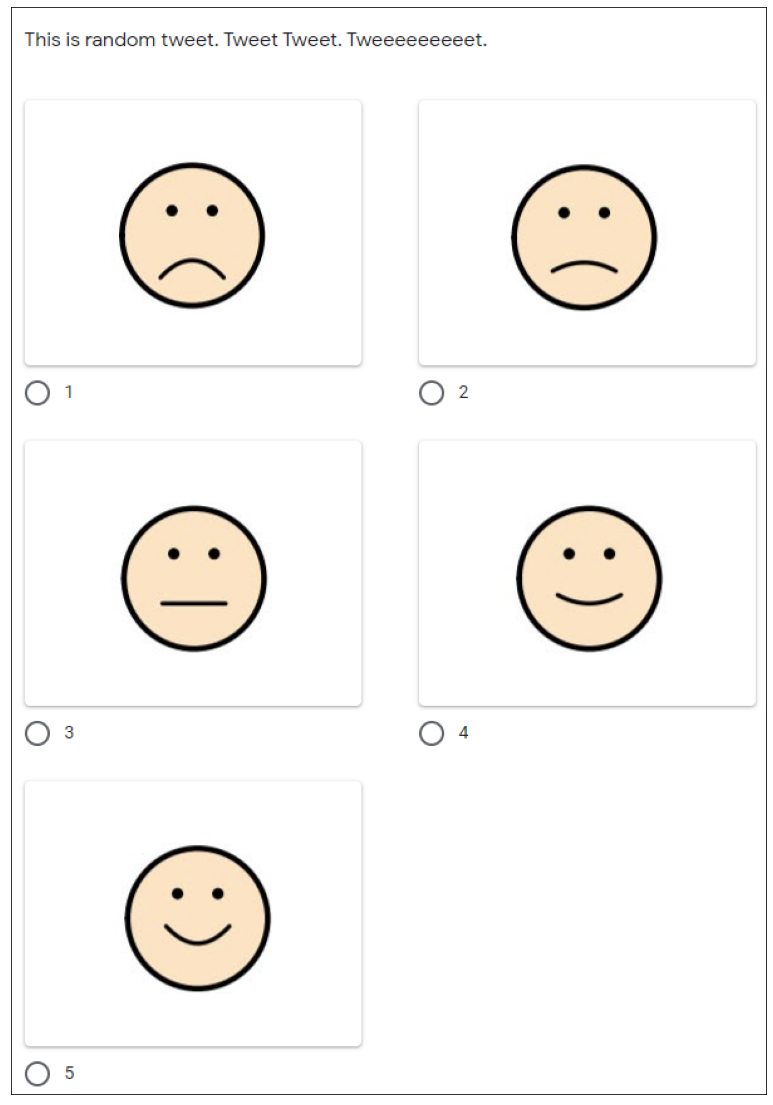

In [3]:
img = plt.imread('sample.png')
plt.figure(figsize=(40,20))
plt.imshow(img)
plt.xticks([])
plt.yticks([]);

In addition, I recruited one more friend and gave the same test, but with a different instruction. I asked her to evaluate her feeling toward the tweet, which I expected to be very different from evaluating the sentiment of the tweet itself. This was to purposefully create a "deviant" coder to demonstrate that the model could weight out the bad coder in my [coding presentation](https://github.com/nwrim/Content-Analysis-2020/blob/master/Coding%20Presentation.pdf).

Let's first load the annotations and take a look at them:

In [4]:
# loading annotations
x = np.loadtxt("annotations.txt").T # transpose because google survey form is different from expected
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

In [5]:
# showing annotations
anno.annotations

array([[4, 3, 3, 3, 3, 2, 1, 3, 3, 3, 1],
       [3, 2, 3, 3, 1, 2, 3, 3, 3, 3, 1],
       [4, 4, 3, 4, 3, 3, 3, 3, 3, 4, 1],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 2],
       [0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 0, 0, 1, 2, 2, 1, 0, 1],
       [3, 3, 3, 2, 3, 2, 2, 2, 4, 2, 0],
       [2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1],
       [0, 0, 1, 1, 2, 1, 1, 0, 0, 0, 1],
       [0, 1, 1, 2, 0, 0, 0, 1, 0, 0, 0],
       [4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1],
       [2, 1, 1, 0, 0, 2, 2, 2, 2, 1, 0],
       [3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1],
       [0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0],
       [4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 0],
       [2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 1],
       [4, 3, 1, 2, 3, 1, 4, 2, 0, 1, 3]])

In [6]:
# showing labels
anno.labels

[1.0, 2.0, 3.0, 4.0, 5.0]

In [7]:
# showing frequency of each label
pyanno.measures.agreement.labels_frequency(anno.annotations, 5)

array([0.20454545, 0.27727273, 0.16818182, 0.25      , 0.1       ])

It looks like more tweets received annotation for negative sentimentality (0 and 1) than positive sentimentality (4 and 5). This is unsurprising because since the tweets were related to an ongoing pandemic, it is likely that the dataset contained more negative tweets than positive tweets. Since I randomly sampled the tweets and did not balance for the sentimentality, there were likely more negative tweets in the sampled 20 tweets.

Let's plot the confusion matrix between two coders who got the right instructions (coder 0 and coder 1).

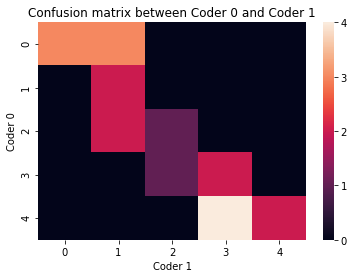

In [8]:
# drawing confusion matrix between two normal coders
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],5)
fig, ax = plt.subplots()
seaborn.heatmap(c, ax=ax, cbar_kws=dict(ticks=[0,1,2,3,4]))
ax.set_title('Confusion matrix between Coder 0 and Coder 1')
ax.set_ylabel('Coder 0')
ax.set_xlabel('Coder 1')
plt.show()

We can see that two coders seem to agree with each other quite a lot since all the colored points (indicating there is an instance of that codings) were at the diagonal axis or near the diagonal axis.

Now let's plot the confusion matrix between a coder who got the right instruction (coder 0) and a coder who got the wrong instruction (coder 10).

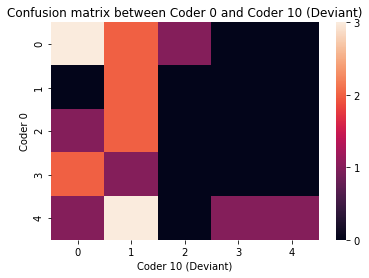

In [9]:
# drawing confusion matrix between normal coder and deviant coder
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,10],5)
fig, ax = plt.subplots()
seaborn.heatmap(c, ax=ax, cbar_kws=dict(ticks=[0,1,2,3,4]))
ax.set_title('Confusion matrix between Coder 0 and Coder 10 (Deviant)')
ax.set_ylabel('Coder 0')
ax.set_xlabel('Coder 10 (Deviant)')
plt.show()

Here, we can see that the two coders did not agree with each other so much since many colored points are far off the diagonal axis. We can see that the deviant coder tended to rate tweets quite negatively than a coder who got the right instruction.

Let's look at some metrics of the agreement to see the trend shown in the confusion matrix can be shown quantitatively. I will use Cohen's weighted 𝜅, since the labels here are ordinal, not categorical.

In [10]:
print("Cohen's weighted Kappa for Coder 0 and 1:", np.round(cohens_weighted_kappa(anno.annotations[:, 0], anno.annotations[:, 1]), 3))
print("Cohen's weighted Kappa for Coder 0 and 10 (Deviant coder):", np.round(cohens_weighted_kappa(anno.annotations[:, 0], anno.annotations[:, 10]), 3))

Cohen's weighted Kappa for Coder 0 and 1: 0.704
Cohen's weighted Kappa for Coder 0 and 10 (Deviant coder): 0.162


Indeed, we can see that while coder 0 and 1 agreed with each other quite substantively, coder 0 and coder 10 (the deviant coder) did not agree with each other that much.

Now let's average the Cohen's weighted 𝜅s to see the overall agreement:

In [11]:
print("averaged Cohen's weighted Kappa across all coders:", np.round(pairwise_metric_average(cohens_weighted_kappa, anno.annotations), 3))
print("averaged Cohen's weighted Kappa except the deviant coder:", np.round(pairwise_metric_average(cohens_weighted_kappa, anno.annotations[:, :10]), 3))

averaged Cohen's weighted Kappa across all coders: 0.519
averaged Cohen's weighted Kappa except the deviant coder: 0.61


We can see that coders tend to agree quite a lot if we exclude the deviant coder, but the inclusion of the deviant coder decreases the 𝜅 about 0.1.

Let's visualize Cohen's weighted 𝜅s using a pairwise matrix:

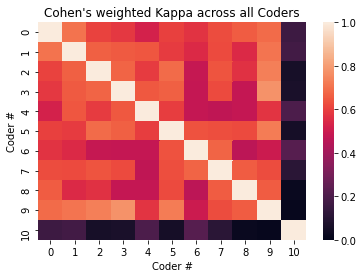

In [12]:
m = pairwise_matrix(cohens_weighted_kappa, anno.annotations)
fig, ax = plt.subplots()
seaborn.heatmap(m, ax=ax, vmin=0, vmax=1)
ax.set_title("Cohen's weighted Kappa across all Coders")
ax.set_ylabel('Coder #')
ax.set_xlabel('Coder #')
plt.show()

We can see that the deviant coder (coder 10) did not agree with other coders at all! This is expected because the coder got the wrong instruction. Coder 4 and 6 seem to be less agreeing with other coders too but the magnitudes of disagreements are quite smaller than that of coder 10.

Let's try another metric - Krippendorff's 𝛼 looks like a good option since the annotations here are ordinal, not categorical.

In [13]:
print("Krippendorff's alpha across all coders:", np.round(krippendorffs_alpha(anno.annotations), 3))
print("Krippendorff's alpha except the deviant coder:", np.round(krippendorffs_alpha(anno.annotations[:, :10]), 3))

Krippendorff's alpha across all coders: 0.656
Krippendorff's alpha except the deviant coder: 0.767


We see the same trend here - while coders who got the right instructions agreed with each other quite well on average, and the inclusion of one deviant coder decrease the 𝛼 value more than 0.1.

Now let's take a look at more traditional correlation metrics - Pearson's 𝜌 and Spearman's 𝜌:

In [14]:
print("Pearson's rho for Coder 0 and 1:", np.round(pearsons_rho(anno.annotations[:, 0], anno.annotations[:, 1]), 3))
print("Pearson's rho for Coder 0 and 10 (Deviant coder):", np.round(pearsons_rho(anno.annotations[:, 0], anno.annotations[:, 10]), 3))
print("averaged Pearson's rho across all coders:", np.round(pairwise_metric_average(pearsons_rho, anno.annotations), 3))
print("averaged Pearson's rho except the deviant coder:", np.round(pairwise_metric_average(pearsons_rho, anno.annotations[:, :10]), 3))

Pearson's rho for Coder 0 and 1: 0.919
Pearson's rho for Coder 0 and 10 (Deviant coder): 0.302
averaged Pearson's rho across all coders: 0.689
averaged Pearson's rho except the deviant coder: 0.785


In [15]:
print("Spearman's rho for Coder 0 and 1:", np.round(spearmans_rho(anno.annotations[:, 0], anno.annotations[:, 1]), 3))
print("Spearman's rho for Coder 0 and 10 (Deviant coder):", np.round(spearmans_rho(anno.annotations[:, 0], anno.annotations[:, 10]), 3))
print("averaged Spearman's rho across all coders:", np.round(pairwise_metric_average(spearmans_rho, anno.annotations), 3))
print("averaged Spearman's rho except the deviant coder:", np.round(pairwise_metric_average(spearmans_rho, anno.annotations[:, :10]), 3))

Spearman's rho for Coder 0 and 1: 0.917
Spearman's rho for Coder 0 and 10 (Deviant coder): 0.238
averaged Spearman's rho across all coders: 0.669
averaged Spearman's rho except the deviant coder: 0.789


Again, we see a similar pattern.

Finally, let's calculate some metrics for categorical annotation, just to see that if we use these metrics, their value will be quite lower than the metrics for ordinal annotations.

First, let's try Scott's  𝜋:

In [16]:
print("Scott's pi for Coder 0 and 1:", np.round(scotts_pi(anno.annotations[:,0], anno.annotations[:,1]), 3))
print("Scott's pi for Coder 0 and 10 (Deviant coder):", np.round(scotts_pi(anno.annotations[:,0], anno.annotations[:,10]), 3))
print("averaged Scott's pi across all coders:", np.round(pairwise_metric_average(scotts_pi, anno.annotations), 3))
print("averaged Scott's pi except the deviant coder:", np.round(pairwise_metric_average(scotts_pi, anno.annotations[:, :10]), 3))

Scott's pi for Coder 0 and 1: 0.369
Scott's pi for Coder 0 and 10 (Deviant coder): 0.071
averaged Scott's pi across all coders: 0.307
averaged Scott's pi except the deviant coder: 0.377


Now  Fleiss'  𝜅:

In [17]:
print("Fleiss' Kappa across all coders:", np.round(fleiss_kappa(anno.annotations), 3))
print("Fleiss' Kappa except the deviant coder:", np.round(fleiss_kappa(anno.annotations[:, :10]), 3))

Fleiss' Kappa across all coders: 0.328
Fleiss' Kappa except the deviant coder: 0.389


Finally Cohen's 𝜅:

In [18]:
print("Cohen's Kappa for Coder 0 and 1:", np.round(cohens_kappa(anno.annotations[:,0], anno.annotations[:,1]), 3))
print("Cohen's Kappa for Coder 0 and 10 (Deviant coder):", np.round(cohens_kappa(anno.annotations[:,0], anno.annotations[:,10]), 3))
print("averaged Cohen's Kappa across all coders:", np.round(pairwise_metric_average(cohens_kappa, anno.annotations), 3))
print("averaged Cohen's Kappa except the deviant coder:", np.round(pairwise_metric_average(cohens_kappa, anno.annotations[:, :10]), 3))

Cohen's Kappa for Coder 0 and 1: 0.398
Cohen's Kappa for Coder 0 and 10 (Deviant coder): 0.141
averaged Cohen's Kappa across all coders: 0.332
averaged Cohen's Kappa except the deviant coder: 0.394


We can see that metrics for categorical annotations show much less value than metrics for ordinal annotations. This is because they do not take into account that in the ordinal scale, values that deviate by a small degree should be weighted less than values that deviate by a large degree. Since our annotations are ordinal, it will be better to use metrics for such scale (or correlation metrics).

## Conclusion

It seems that humans are able to quite reliably annotate the sentimentality of tweets. However, it seems like the instruction really will make a difference. We should be careful to make the coders understand that the sentiment of the tweet itself is to be evaluated, not the feeling of coders toward the tweet.

# Models

In [19]:
def makeQuestionComparison(model, anno_target, num_questions = 20):
    votes = []
    for r in anno_target.annotations:
        v = [0] * len(anno_target.labels)
        votes.append(v)
        for a in r:
            if a > -1:
                v[a] += 1
    votes_array = np.array(votes)
    posterior = model.infer_labels(anno_target.annotations)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)

    seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
    seaborn.heatmap(np.nan_to_num(posterior,0)[:num_questions], annot=True, ax =ax1)
    ax1.set_title("Model")
    ax2.set_title("Votes")
    return fig, (ax1, ax2)

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, use the results of your content annotation survey to predict high and low-quality analysts, then predict MAP estimates for your codes in question. What do these estimates suggest about the distribution of skill among your coders? How different are these estimates from a majority vote?

I will first use Model B with 𝜃s to predict high and low-quality annotators. To follow the instructions, I will use MAP to estimate the model parameters.

In [20]:
# initialize model Bt
model0 = ModelBt.create_initial_state(5, 11)
# use MAP to estimate model parameters
model0.map(anno.annotations)

Let's take a look at estimated 𝜃s:

In [21]:
print(model0.theta)

[0.55383936 0.55360983 0.68399888 0.73482912 0.64364782 0.87280643
 0.73122874 0.69531852 0.64645441 0.69412081 0.30436273]


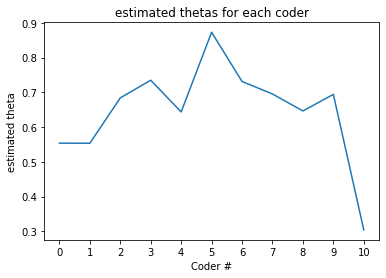

In [22]:
seaborn.lineplot(x=range(11), y=model0.theta)
plt.title('estimated thetas for each coder')
plt.xticks(range(11))
plt.xlabel('Coder #')
plt.ylabel('estimated theta');

According to `pyanno` documentation, "theta[j] parametrizes the probability that annotator j reports label". We can see the deviant coder (coder 10) has very low theta, suggesting that coder 10's annotations will get very low weight.

In addition, let's plot the accuracy of each annotator inferred from the model:

In [23]:
samples = model0.sample_posterior_over_accuracy(anno.annotations, nsamples=20)
y =  samples.mean(axis=0)
y_ci = samples.std(axis=0)

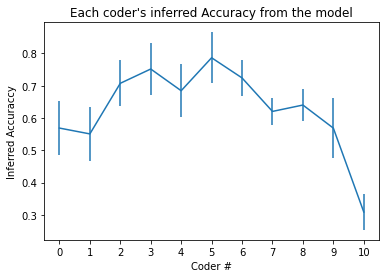

In [24]:
plt.figure()
plt.errorbar(range(11),y, yerr = y_ci)
plt.xticks(range(11))
plt.title("Each coder's inferred Accuracy from the model")
plt.xlabel('Coder #')
plt.ylabel('Inferred Accuraccy')
plt.show()

We can see that coder 10 has terrible accuracy, but other coders didn't do that terribly, although we do see some relatively worse coders even though they got the correct instructions. This suggests that there is some variation in the coder skills, but the difference does not seem to be phenomenal.

Now let's try to infer the labels using the model. I will plot the MAP estimate for all 20 tweets alongside the number of votes for each rating which each tweet got.

In [25]:
posterior = model0.infer_labels(anno.annotations)

In [26]:
# create an array for vote majority
votes = []
for r in anno.annotations:
    v = [0] * len(anno.labels)
    votes.append(v)
    for a in r:
        if a > -1:
            v[a] += 1
votes_array = np.array(votes)

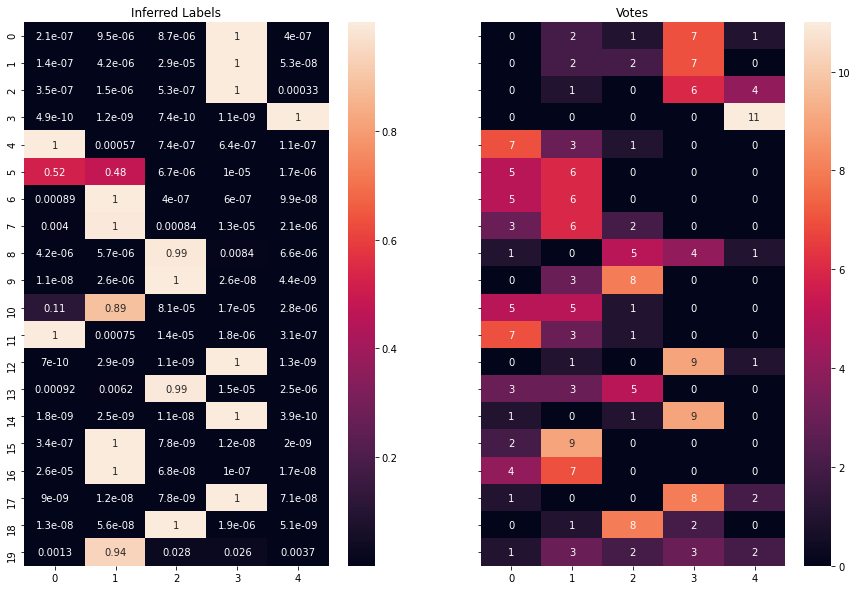

In [27]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)
seaborn.heatmap(votes_array, annot = True, ax=ax2)
seaborn.heatmap(posterior, annot=True, ax =ax1)
ax1.set_title("Inferred Labels")
ax2.set_title("Votes")
plt.show()

We can see that the MAP estimates follow the majority votes except for the tweet in row 5. Let's subset some of the tweets where the vote is tied or really close:

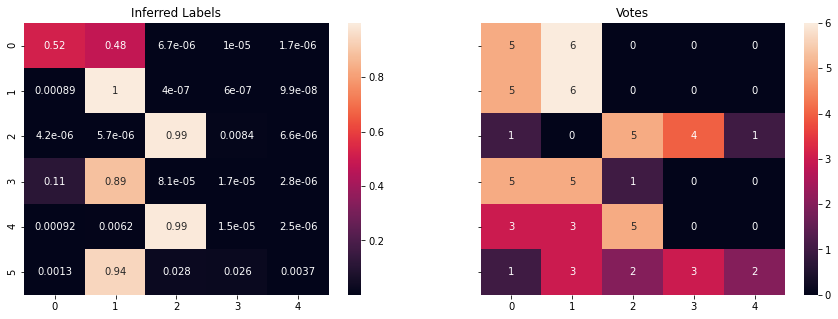

In [28]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 5), sharey=True)
seaborn.heatmap(votes_array[[5,6,8,10,13,19], :], annot = True, ax=ax2)
seaborn.heatmap(posterior[[5,6,8,10,13,19], :], annot=True, ax =ax1)
ax1.set_title("Inferred Labels")
ax2.set_title("Votes")
plt.show()

We can see that although the votes are tied or really close, the MAP estimates strongly suggest one label over the others except for one case (row 0 in the subset or row 5 in the entire set). This suggests that perhaps relatively more reliable voters (who get more weights) agreed on a single label even in cases like this.

Now let's try everything with model B.

In [29]:
# initialize model Bt
model1 = ModelB.create_initial_state(5, 11)
model1.map(anno.annotations)

C:\Users\nousl\Anaconda3\envs\macs60000\lib\site-packages\pyanno\util.py:80: RuntimeWarning: divide by zero encountered in log
  log_theta = ninf_to_num(log(theta))


In [30]:
print(model1.theta)

[[[8.11932996e-001 1.41025183e-001 4.70418213e-002 0.00000000e+000
   0.00000000e+000]
  [2.41262293e-001 6.09941397e-001 1.12915914e-001 3.58803957e-002
   4.77423281e-147]
  [3.60126044e-002 1.08039126e-001 6.42897594e-001 1.41024885e-001
   7.20257909e-002]
  [0.00000000e+000 3.56074306e-002 1.06823430e-001 6.08317738e-001
   2.49251401e-001]
  [0.00000000e+000 0.00000000e+000 5.00000000e-002 1.50000000e-001
   8.00000000e-001]]

 [[7.59086645e-001 1.93915420e-001 4.69979345e-002 0.00000000e+000
   0.00000000e+000]
  [1.73966459e-001 6.82511953e-001 1.07641193e-001 3.58803952e-002
   0.00000000e+000]
  [3.60125997e-002 1.74736511e-001 5.76203094e-001 1.77035205e-001
   3.60125905e-002]
  [0.00000000e+000 3.56074371e-002 1.42428005e-001 6.79534840e-001
   1.42429718e-001]
  [0.00000000e+000 0.00000000e+000 5.00000000e-002 1.50000000e-001
   8.00000000e-001]]

 [[7.13906066e-001 2.39096000e-001 4.69979346e-002 0.00000000e+000
   0.00000000e+000]
  [1.72579020e-001 6.83895285e-001 1.07

According to `pyanno` documentations, "theta[j,k,k’] is the probability that annotator j reports label k’ for an item whose real label is k". There will be so many ways to plot this since the parameters are in three dimensions, but I will just plot the thetha[j,k,k]s.

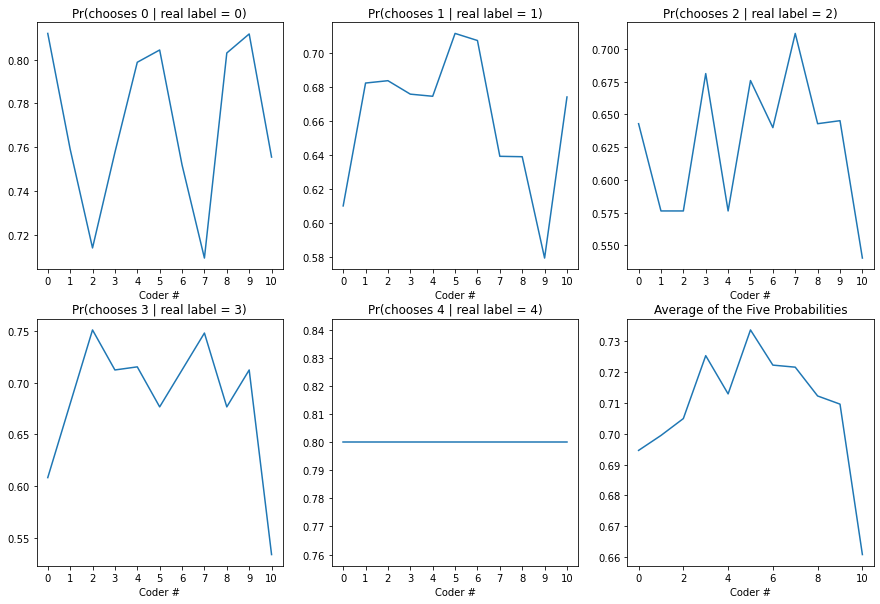

In [31]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15,10))
for i in range(2):
    for j in range(3):
        if i == 1 and j == 2:
            break
        seaborn.lineplot(x=range(11), y=model1.theta[:, i * 3 + j, i * 3 + j], ax=ax[i][j])
        ax[i][j].set_xticks(range(11))
        ax[i][j].set_title(f'Pr(chooses {i * 3 + j} | real label = {i * 3 + j})')
        ax[i][j].set_xlabel('Coder #')
avg = model1.theta[:, 0, 0].copy()
for i in range(1,5):
    avg += model1.theta[:, i, i]
seaborn.lineplot(x=range(11), y=avg/5, ax=ax[1][2])
ax[1][2].set_title('Average of the Five Probabilities')
ax[1][2].set_xlabel('Coder #');

We can see that Coder 10 has the lowest probability in labeling 1, 2, and 3 correctly but there are coders with worse probability in labeling 0. Theta for label 4 is the same across all coders since there was only one case where the inferred label was 4 and all coders voted for label 4 in that case (see below). Overall, it seems that there is some variation in coder's skills, but it seems that they are doing fairly well except the deviant coder.

Now let's plot the inferred label the same way we did for Model B with 𝜃s:

In [32]:
posterior = model1.infer_labels(anno.annotations)

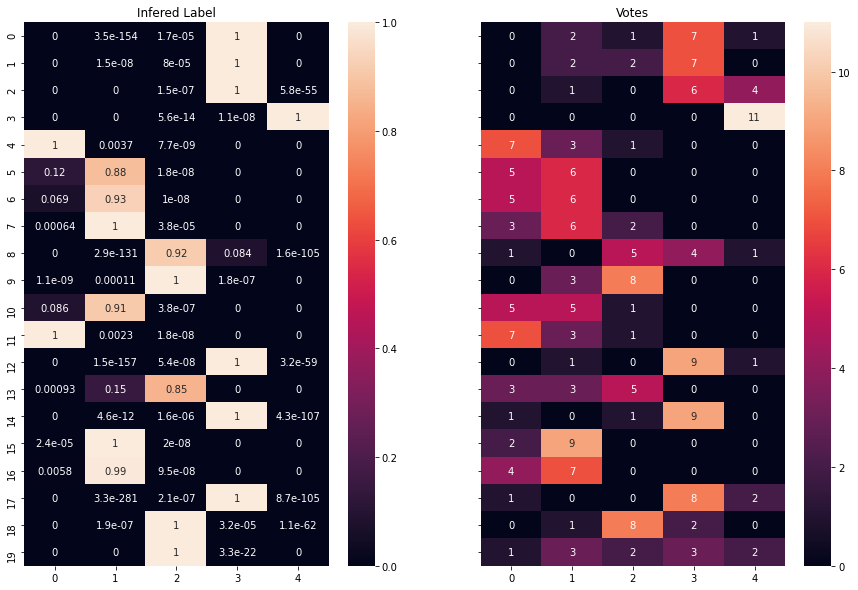

In [33]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)
seaborn.heatmap(votes_array, annot = True, ax=ax2)
seaborn.heatmap(posterior, annot=True, ax =ax1)
ax1.set_title("Infered Label")
ax2.set_title("Votes")
plt.show()

Let's subset some of the tweets where the vote is tied or really close again:

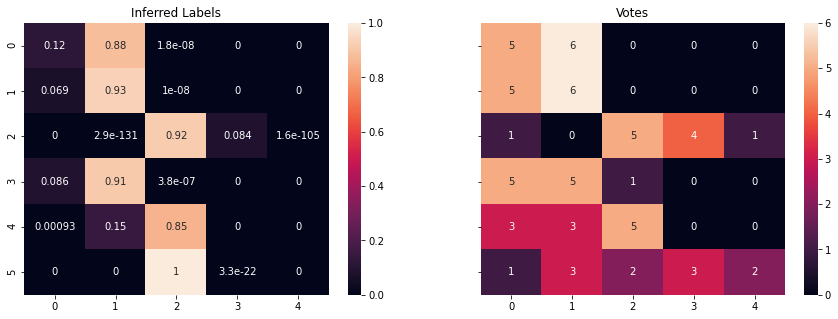

In [34]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 5), sharey=True)
seaborn.heatmap(votes_array[[5,6,8,10,13,19], :], annot = True, ax=ax2)
seaborn.heatmap(posterior[[5,6,8,10,13,19], :], annot=True, ax =ax1)
ax1.set_title("Inferred Labels")
ax2.set_title("Votes")
plt.show()

Again, we can see that although the votes are tied or really close, the MAP estimates strongly suggest one label over the others. Even the one that had really close two MAP estimates in Model B with 𝜃s has a decisive value in Model B (row 0 on the subset or row 5 on the entire data).

Now let's see how different is the inferred label from each model by drawing a confusion matrix:

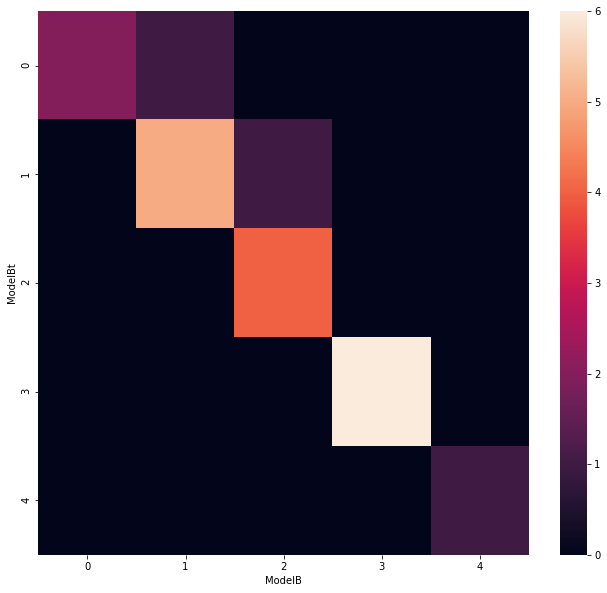

In [35]:
x = np.array([[3,3,3,4,0,0,1,1,2,2,1,0,3,2,3,1,1,3,2,1],
              [3,3,3,4,0,1,1,1,2,2,1,0,3,2,3,1,1,3,2,2]]).T
anno = AnnotationsContainer.from_array(x, missing_values=[-1])
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1], 5)
fig, ax = plt.subplots(figsize=(11,10))
seaborn.heatmap(c, ax=ax)
ax.set_ylabel('ModelBt')
ax.set_xlabel('ModelB')
plt.show()

As expected, the inferred label from each model seems to agree with each other a lot. They agreed on all labels except two tweets (tweet 4 and 19 from the whole dataset)

## Conclusion

It seems that the models could successfully down weight the less skillful coders and up weight the more skillful coders. There do seem to be some variation in coding sentimentality of tweets, but the difference does not seem to be very large (if we do not consider the deviant coder). However, the coders were all from an educated population (all of them have a Bachelor's degree or is currently attending University), so it should be tested on a crowd-sourcing platform to really see the distribution of skills. The estimates were almost the same with the majority votes, but we can see that even if there was a tie or really close vote, the MAP estimate seems to decide what is the inferred label in most cases by weighting the coders.

# Extra codes for coding presentation

The following are some extra codes for the coding presentation. These codes try to compare the inferred labels from the labels generated using [`nltk.sentiment.vader.SentimentIntensityAnalyzer`](https://www.nltk.org/api/nltk.sentiment.html). 

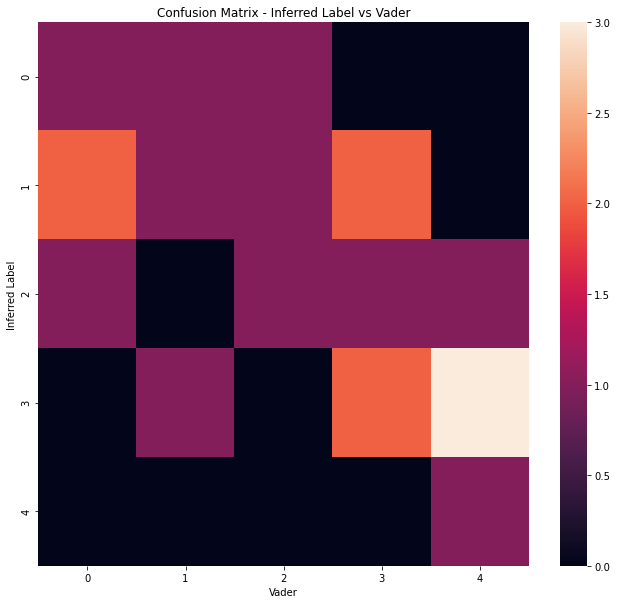

In [36]:
x = np.array([[3,3,3,4,0,0,1,1,2,2,1,0,3,2,3,1,1,3,2,1],
              [4,4,3,4,0,1,0,3,4,2,0,2,3,3,4,1,2,1,0,3]]).T
anno = AnnotationsContainer.from_array(x, missing_values=[-1])
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],5)
fig, ax = plt.subplots(figsize=(11,10))
seaborn.heatmap(c, ax=ax)
ax.set_ylabel('Inferred Label')
ax.set_xlabel('Vader')
ax.set_title('Confusion Matrix - Inferred Label vs Vader')
plt.show()

In [37]:
print("Cohen's weighted Kappa between inferred label and vader:", np.round(cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1]), 3))
print("Pearson's rho between inferred label and vader:", np.round(pearsons_rho(anno.annotations[:,0], anno.annotations[:,1]),3))
print("Spearman's rho between inferred label and vader:", np.round(spearmans_rho(anno.annotations[:,0], anno.annotations[:,1]),3))

Cohen's weighted Kappa between inferred label and vader: 0.355
Pearson's rho between inferred label and vader: 0.607
Spearman's rho between inferred label and vader: 0.63


Following code treats the labels from Vader as a separate annotator and estimate the coder accuracy:

In [38]:
# load original annotations
x = np.loadtxt("annotations.txt")
# stack the vader sentiment labels and transpose it
x = np.vstack((x, [5,5,4,5,1,2,1,4,5,3,1,3,4,4,5,2,3,2,1,4])).T
# make it to annotation
anno = AnnotationsContainer.from_array(x, missing_values=[-1])
# estimate the model parameters
model = ModelBt.create_initial_state(5, 12)
model.map(anno.annotations)
# generate accuracy
samples = model.sample_posterior_over_accuracy(anno.annotations, nsamples=20)
y =  samples.mean(axis=0)#.mean(axis = 1).mean(axis = 1)
y_ci = samples.std(axis=0)#.mean(axis = 1).mean(axis = 1)

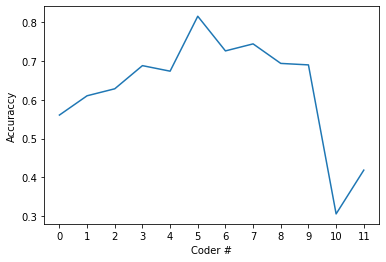

In [39]:
# make plots
plt.figure()
plt.errorbar(range(12),y, yerr = y_ci)
plt.xticks(range(12))
plt.xlabel('Coder #')
plt.ylabel('Accuraccy')
plt.show()